In [316]:
import requests
from bs4 import BeautifulSoup as BS
import pandas as pd
import timeit
import re
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

In [317]:
election_results = pd.read_csv("../../webscraping_open_secrets-silver-ish-sharks/data/election_results.csv")

In [318]:
election_results.rename(columns={})

election_results

,Unnamed: 0,Candidate_name,Party,State,District,Incumbent,Winner,Raised,Spent,percent_raised,percent_spent
0,0,Jerry Carl,R,Alabama,1,False,True,1971321,1859349,96.095624,95.925703
1,1,James Averhart,D,Alabama,1,False,False,80095,78973,3.904376,4.074297
2,0,Barry Moore,R,Alabama,2,False,True,650807,669368,92.070532,92.281307
3,1,Phyllis Harvey,D,Alabama,2,False,False,56050,55988,7.929468,7.718693
4,0,Mike D Rogers,R,Alabama,3,True,True,1193111,1218564,95.956760,96.747133
...,...,...,...,...,...,...,...,...,...,...,...
889,1,Tricia Zunker,D,Wisconsin,7,False,False,1261957,1232690,32.362718,32.894277
890,0,Mike Gallagher,R,Wisconsin,8,True,True,3202905,2841801,88.480898,87.663451
891,1,Amanda Stuck,D,Wisconsin,8,False,False,416978,399916,11.519102,12.336549
892,0,Liz Cheney,R,Wyoming,1,True,True,3003883,3060167,95.711395,95.857821


In [319]:
URL_states = "https://www.britannica.com/topic/United-States-House-of-Representatives-Seats-by-State-1787120"
URL_abb = "https://www.50states.com/abbreviations.htm"

response_states = requests.get(URL_states)
response_abb = requests.get(URL_abb)

soup = BS(response_states.text)

soup_abb = BS(response_abb.text)

abb = pd.read_html(str(soup_abb.find('table')))[0]
abb = abb.drop(columns='STANDARD ABBREVIATION')
abb = abb.rename(columns={'US STATE':'state', 'POSTAL ABBREVIATION':'state_abb'})


states = pd.read_html(str(soup.find('table')))[0]
states = states.drop([50])

state_districts = pd.merge(states, abb, on='state')
state_districts['representatives'] = state_districts['representatives'].apply(pd.to_numeric)
display(state_districts.head())
district_count = "Number of US Representatives: " + str(state_districts['representatives'].sum())
district_count

,state,representatives,state_abb
0,Alabama,7,AL
1,Alaska,1,AK
2,Arizona,9,AZ
3,Arkansas,4,AR
4,California,53,CA


'Number of US Representatives: 435'

In [425]:
incumbent_win = election_results[(election_results['Incumbent'] == True) & (election_results['Winner'] == True)]
incumbent_win

,Unnamed: 0,Candidate_name,Party,State,District,Incumbent,Winner,Raised,Spent,percent_raised,percent_spent,nothing,constant,numb_candidates
4,0,Mike D Rogers,R,Alabama,3,True,True,1193111,1218564,95.956760,96.747133,1,1,1
6,0,Robert B Aderholt,R,Alabama,4,True,True,1255076,1323812,96.459423,96.710075,1,1,1
8,0,Mo Brooks,R,Alabama,5,True,True,655365,210045,100.000000,100.000000,1,1,1
9,0,Gary Palmer,R,Alabama,6,True,True,907219,909082,100.000000,100.000000,1,1,1
10,0,Terri Sewell,D,Alabama,7,True,True,2168165,1495957,100.000000,100.000000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,0,Gwen Moore,D,Wisconsin,4,True,True,1183995,1166739,100.000000,100.000000,1,1,1
886,0,Glenn S Grothman,R,Wisconsin,6,True,True,1815756,1736659,86.320334,87.601787,1,1,1
888,0,Tom Tiffany,R,Wisconsin,7,True,True,2637459,2514740,67.637282,67.105723,1,1,1
890,0,Mike Gallagher,R,Wisconsin,8,True,True,3202905,2841801,88.480898,87.663451,1,1,1


In [433]:
no_comp = election_results
no_comp['constant'] = 1
no_comp = no_comp.pivot_table(values='constant', index = ['State', 'District'], aggfunc=sum)
#no_comp = no_comp[no_comp.constant !=1]
no_comp = no_comp.reset_index()
no_comp = no_comp.rename(columns={'constant':'numb_candidates'})
no_comp = pd.merge(no_comp, election_results, on=['State', 'District'])
no_comp = no_comp[no_comp.numb_candidates_x !=1]
no_comp = no_comp.rename(columns={'numb_candidates_x': 'numb_candidates'})
no_comp = no_comp.drop(columns=['Unnamed: 0', 'nothing', 'constant', 'numb_candidates_y'])
no_comp

,State,District,numb_candidates,Candidate_name,Party,Incumbent,Winner,Raised,Spent,percent_raised,percent_spent
0,Alabama,1,2,Jerry Carl,R,False,True,1971321,1859349,96.095624,95.925703
1,Alabama,1,2,James Averhart,D,False,False,80095,78973,3.904376,4.074297
2,Alabama,2,2,Barry Moore,R,False,True,650807,669368,92.070532,92.281307
3,Alabama,2,2,Phyllis Harvey,D,False,False,56050,55988,7.929468,7.718693
4,Alabama,3,2,Mike D Rogers,R,True,True,1193111,1218564,95.956760,96.747133
...,...,...,...,...,...,...,...,...,...,...,...
889,Wisconsin,7,2,Tricia Zunker,D,False,False,1261957,1232690,32.362718,32.894277
890,Wisconsin,8,2,Mike Gallagher,R,True,True,3202905,2841801,88.480898,87.663451
891,Wisconsin,8,2,Amanda Stuck,D,False,False,416978,399916,11.519102,12.336549
892,Wyoming,1,2,Liz Cheney,R,True,True,3003883,3060167,95.711395,95.857821


In [321]:
incumbent_agg = incumbent_win['State'].value_counts().reset_index()
incumbent_agg = incumbent_agg.rename(columns={'index':'state', 'State':'numb_incumb_wins'})
incumbent_agg['numb_incumb_wins'].sum()
#incumbent_agg.head()

371

In [322]:
incumbent_agg.head()

,state,numb_incumb_wins
0,California,47
1,Texas,29
2,Florida,22
3,New York,21
4,Pennsylvania,17


In [323]:
incumbent_agg = pd.merge(state_districts, incumbent_agg, how='outer').fillna(value=0)
incumbent_agg.head()

,state,representatives,state_abb,numb_incumb_wins
0,Alabama,7,AL,5.0
1,Alaska,1,AK,1.0
2,Arizona,9,AZ,9.0
3,Arkansas,4,AR,4.0
4,California,53,CA,47.0


In [339]:
incumbent_lost_all = election_results[(election_results['Incumbent']  == True) & (election_results['Winner'] == False)]
incumbent_lost.head()

,state,numb_incumb_losses
0,California,3
1,New York,2
2,Florida,2
3,Utah,1
4,South Carolina,1


In [340]:
incumbent_lost = incumbent_lost_all['State'].value_counts()
incumbent_lost = pd.DataFrame(incumbent_lost)
incumbent_lost = incumbent_lost.reset_index()
incumbent_lost =incumbent_lost.rename(columns={'index':'state', 'State':'numb_incumb_losses'})
incumbent_lost

,state,numb_incumb_losses
0,California,3
1,New York,2
2,Florida,2
3,Utah,1
4,South Carolina,1
5,Iowa,1
6,Hawaii,1
7,Pennsylvania,1
8,New Mexico,1
9,Minnesota,1


In [341]:
incumbent_agg = pd.merge(incumbent_agg, incumbent_lost, how="outer").fillna(value = 0)

incumbent_agg['no_incumbent_run'] = incumbent_agg['representatives'] - incumbent_agg['numb_incumb_wins'] - incumbent_agg['numb_incumb_losses']
incumbent_agg['perc_incumb_win'] = (incumbent_agg['numb_incumb_wins']/incumbent_agg['representatives'] * 100).round(decimals=2)
incumbent_agg['perc_incumb_loss'] = (incumbent_agg['numb_incumb_losses']/incumbent_agg['representatives'] * 100).round(decimals=2)
incumbent_agg['perc_no_incumb_run'] = (incumbent_agg['no_incumbent_run']/incumbent_agg['representatives'] * 100).round(decimals=2)

incumbent_agg.head()

,state,representatives,state_abb,numb_incumb_wins,numb_incumb_losses,no_incumbent_run,perc_incumb_win,perc_incumb_loss,perc_no_incumb_run
0,Alabama,7,AL,5.0,0.0,2.0,71.43,0.00,28.57
1,Alaska,1,AK,1.0,0.0,0.0,100.00,0.00,0.00
2,Arizona,9,AZ,9.0,0.0,0.0,100.00,0.00,0.00
3,Arkansas,4,AR,4.0,0.0,0.0,100.00,0.00,0.00
4,California,53,CA,47.0,3.0,3.0,88.68,5.66,5.66


In [342]:
all_incumb_win_perc = (incumbent_agg['perc_incumb_win'].sum() / incumbent_agg['perc_incumb_win'].count()).round(decimals=2)
print(all_incumb_win_perc)

all_incumb_loss_perc = (incumbent_agg['perc_incumb_loss'].sum() / incumbent_agg['perc_incumb_loss'].count()).round(decimals=2)
print(all_incumb_loss_perc)

all_no_incumb_run_perc = (incumbent_agg['perc_no_incumb_run'].sum() / incumbent_agg['perc_no_incumb_run'].count()).round(decimals=2)
print(all_no_incumb_run_perc)


83.79
4.12
12.09


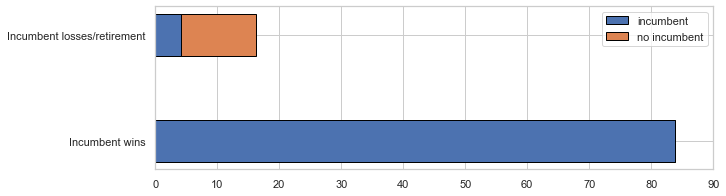

In [343]:
labels = ['Incumbent wins', 'Incumbent losses/retirement']

results = [all_incumb_win_perc, all_incumb_loss_perc]
i_none = [0, all_no_incumb_run_perc]
width = 0.4
num_items = len(labels)
ind = np.arange(num_items)
fig, ax = plt.subplots(figsize=(10,3))

ax.barh(labels, results, width, label = "incumbent", edgecolor='black', linewidth = 1)
ax.barh(labels, i_none, width, left = results, label = "no incumbent", edgecolor='black', linewidth = 1)
ax.set_xticks(np.arange(0, 91, 10))
ax.legend()

plt.show()

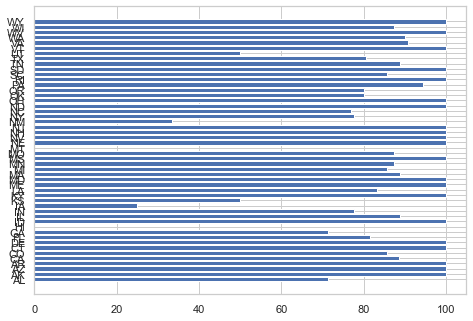

In [402]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = incumbent_agg['state_abb']
y = incumbent_agg['perc_incumb_win']
ax.barh(x, y)

plt.show()

In [ ]:
N = incumbent_agg['state'].count()
x = incumbent_agg['state_abb']
win = incumbent_agg['perc_incumb_win']
lose = incumbent_agg['perc_incumb_loss']
none = incumbent_agg['no_incumbent_run']

ind = np.arrange(N)
width = 0.2

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.barh(ind, win, width)
ax.barh(ind, lose, width, bottom=win)
ax.barh()

plt.show()

C:\Users\Conrad\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\Conrad\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\Conrad\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

25.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\Conrad\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

21.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



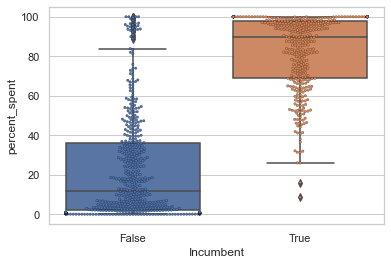

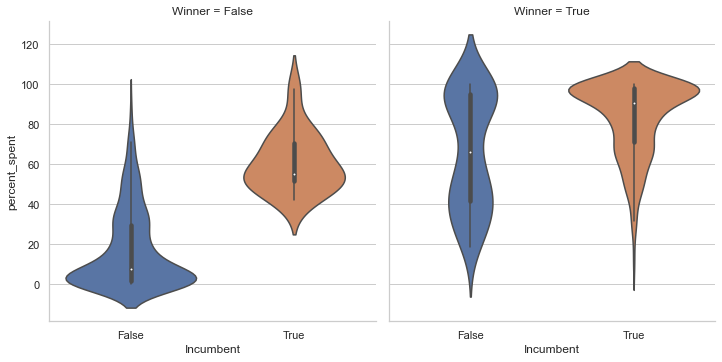

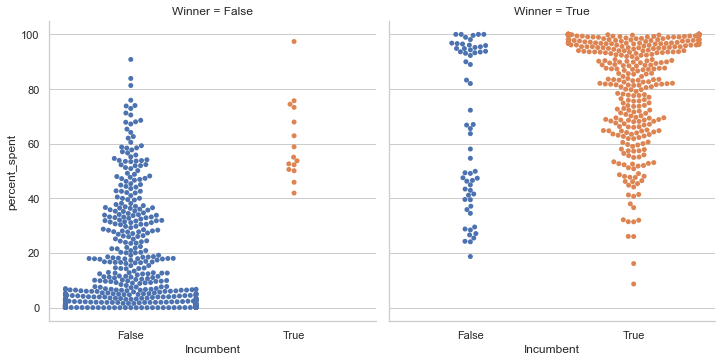

In [392]:
sns.set_theme(style='whitegrid')
ax = sns.boxplot(data=election_results, x='Incumbent', y='percent_spent',orient="v")
ax = sns.swarmplot(data=election_results, x='Incumbent', y='percent_spent',orient="v", edgecolor='black', linewidth=0.2, size=2.5)



g = sns.catplot(data=election_results, x='Incumbent', y='percent_spent', col='Winner', kind='violin')
g = sns.catplot(data=election_results, x='Incumbent', y='percent_spent', col='Winner', kind='swarm')
#election_results.head()

In [345]:
incumbent = election_results[election_results['Incumbent'] == True]
not_incumbent = election_results[election_results['Incumbent'] == False]

print(np.var(incumbent['percent_spent']), np.var(not_incumbent['percent_spent']))
stats.ttest_ind(a=incumbent['percent_spent'], b=not_incumbent['percent_spent'], equal_var=True)

357.0051112873515 683.9763415376178


Ttest_indResult(statistic=37.79600100958994, pvalue=2.197247447667997e-187)

In [357]:
winner_no_incumb = election_results[(election_results['Incumbent']  == False) & (election_results['Winner'] == True)]
loser_no_incumb = election_results[(election_results['Incumbent']  == False) & (election_results['Winner'] == False)]

print(np.var(incumbent_lost_all['percent_spent']), np.var(loser_no_incumb['percent_spent']))
print(np.var(incumbent_win['percent_spent']), np.var(winner_no_incumb['percent_spent']))

print(stats.ttest_ind(a=incumbent_lost_all['percent_spent'], b=loser_no_incumb['percent_spent'], equal_var=True))
print(stats.ttest_ind(a=incumbent_win['percent_spent'], b=winner_no_incumb['percent_spent'], equal_var=True))

198.77586375546656 386.7190502190337
343.71800380978857 778.5122691526635
Ttest_indResult(statistic=8.51307828980207, pvalue=2.4059501517008035e-16)
Ttest_indResult(statistic=6.101329093780424, pvalue=2.3523692621117816e-09)
